# Final Project

This is the Final Project Colab by Taiyo and Ezequiel
Our goal for this Final Project is to:
  - Try to create a ML model which can successfully classify text as AI or Human Generated
  - Find a new way to make it better or different to pre-existing work and products that are already out
  - Learn a lot while doing it

## EDA

So this first part is going to be the EDA on the datasets that we are planning to utilize in this project.

- The first [dataset](https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset) contains both AI Generated essays and human written essays. It has 2 features: the text, and whether it is AI generated or not.

In [1]:
%pip install textstat
%pip install nltk
import nltk


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ezequiel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import textstat
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast


ImportError: cannot import name 'AdamW' from 'transformers' (/Users/ezequiel/myenv/lib/python3.13/site-packages/transformers/__init__.py)

Now we have the CSV file ready to go for EDA

In [4]:
filename = "Training_Essay_Data.csv"
df = pd.read_csv(filename)

### Preprocessing and Data Shape

First we just want to inspect and clean the data if we need to

In [5]:
print("Missing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nLabel distribution:\n", df['generated'].value_counts())
print("\nData shape:", df.shape)

print(df.info())

Missing values:
 text         0
generated    0
dtype: int64

Data types:
 text         object
generated     int64
dtype: object

Label distribution:
 generated
0    17508
1    11637
Name: count, dtype: int64

Data shape: (29145, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB
None


So there is no missing data, and there is slight balance in the label distribution between AI and human generated essays.

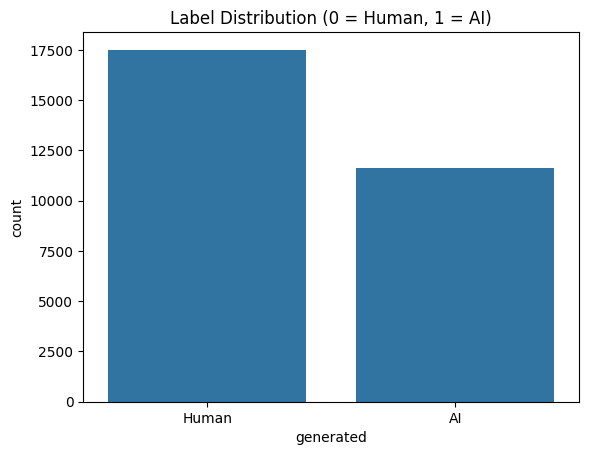

In [6]:
sns.countplot(x='generated', data=df)
plt.title("Label Distribution (0 = Human, 1 = AI)")
plt.xticks([0,1], ['Human', 'AI'])
plt.show()

Quick little visualization to once again see how the distrubtion of the texts is. nWe can see that there are a bit more human generated essays that AI generated ones.

### Analyze text lengths

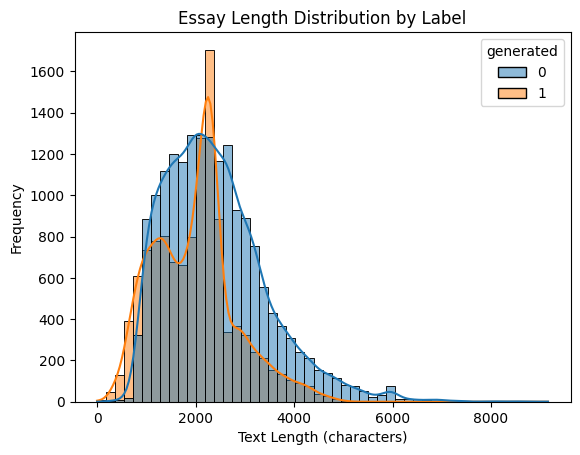


Average text length by label:
generated
0    2403.223669
1    1984.401908
Name: text_length, dtype: float64


In [7]:
df['text_length'] = df['text'].astype(str).apply(len)

sns.histplot(data=df, x='text_length', hue='generated', bins=50, kde=True)
plt.title("Essay Length Distribution by Label")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()

# Compare average lengths
print("\nAverage text length by label:")
print(df.groupby('generated')['text_length'].mean())

- From this visualization, we can see the AI generated text seems to have a higher frequency when it comes to a shorter or more concise essay (around 2000 characters).
- Additionally, there doesn't seem to be many larger length essays that are generated by AI. As we reach 4000 characters, it flattens out.
- On average, AI generated text is less in terms of amount of characters in comparison to human generated
- Overall, I would say that most of the text length for both types of text lie in between 1000-3000 characters

### Word Count

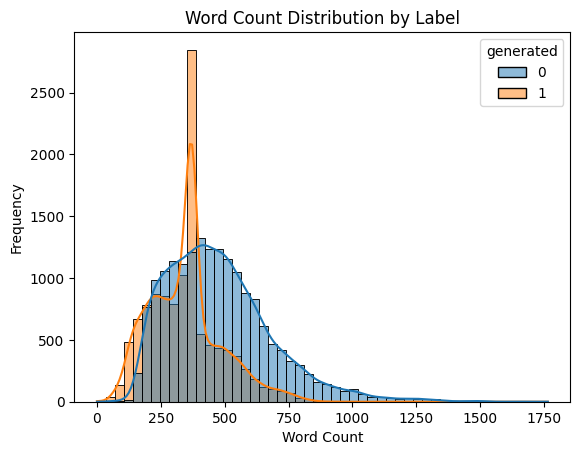

In [8]:
df['word_count'] = df['text'].apply(lambda x: len(word_tokenize(x)))

sns.histplot(data=df, x='word_count', hue='generated', bins=50, kde=True)
plt.title("Word Count Distribution by Label")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

### Get Readability Scores - Gets a score on how readable the text is (higher = better)

In [9]:
# readability - how easy it is to read the text
df['readability'] = df['text'].apply(textstat.flesch_reading_ease)

# gunning fog - how complex the text is (higher score = harder to read)
df['gunning_fog'] = df['text'].apply(textstat.gunning_fog)
# clip gunning_fog to a reasonable range
df['gunning_fog'] = df['gunning_fog'].clip(5, 20)

# smog index - also like gunning fog but mor strict and reliable for shorter texts
df['smog_index'] = df['text'].apply(textstat.smog_index)

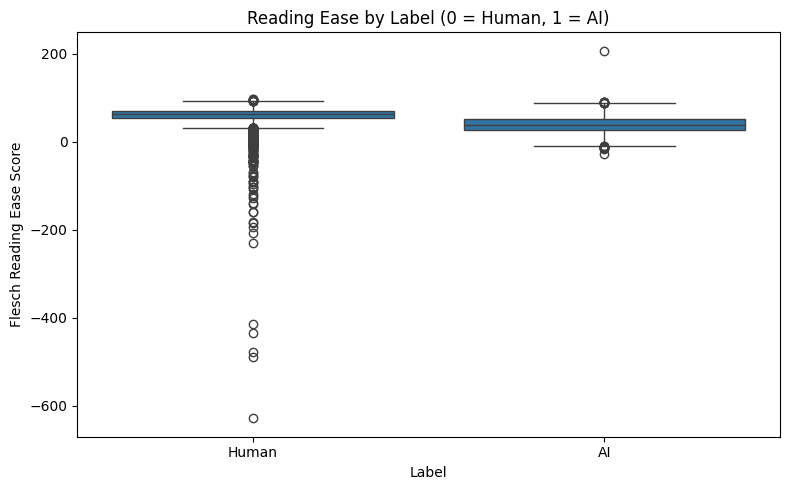

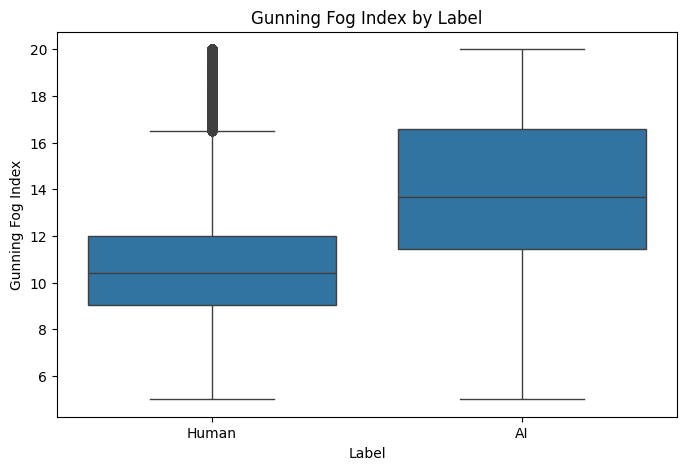

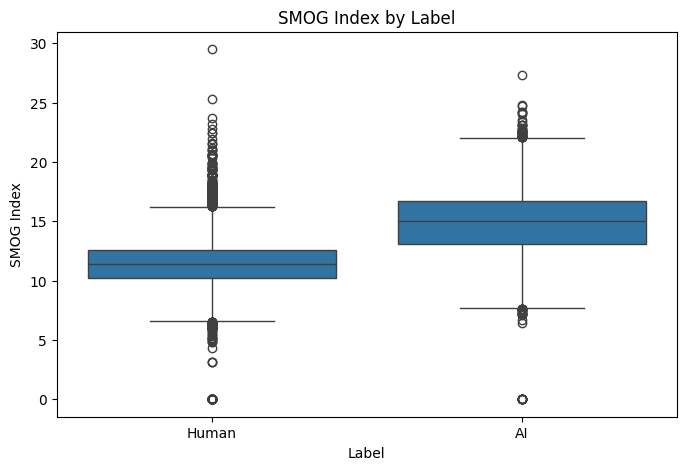

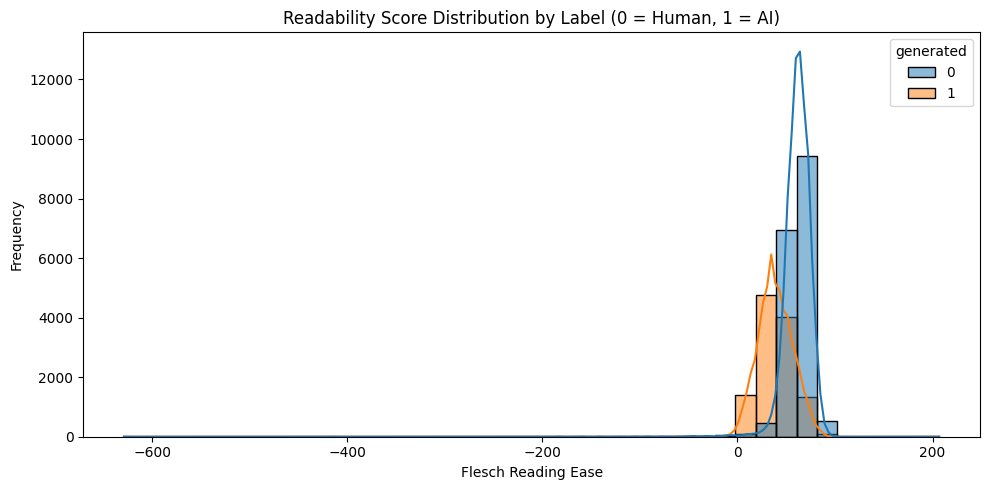

In [10]:
# readability scores
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='generated', y='readability')
plt.title("Reading Ease by Label (0 = Human, 1 = AI)")
plt.xlabel("Label")
plt.ylabel("Flesch Reading Ease Score")
plt.xticks([0, 1], ['Human', 'AI'])
plt.tight_layout()
plt.show()

# Gunning Fog
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='generated', y='gunning_fog')
plt.title("Gunning Fog Index by Label")
plt.xlabel("Label")
plt.ylabel("Gunning Fog Index")
plt.xticks([0,1], ['Human', 'AI'])
plt.show()

# SMOG Index
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='generated', y='smog_index')
plt.title("SMOG Index by Label")
plt.xlabel("Label")
plt.ylabel("SMOG Index")
plt.xticks([0,1], ['Human', 'AI'])
plt.show()

# readability score distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='readability', hue='generated', bins=40, kde=True)
plt.title("Readability Score Distribution by Label (0 = Human, 1 = AI)")
plt.xlabel("Flesch Reading Ease")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Takeaways from the visualizations:
- Humans have higher median scores in terms of readability. This suggests that human-written texts are easier to read
- AI texts have more variation, so there is a mix between it being too complex or too simple. Human texts are more centered and consistent.
- Human texts have a lot of outliers. This could be for reasons like poor grammar, sentence fragments, long/unstructured writing. AI has much fewer outliers which could suggest they are more polished structurally.
- AI-generated text seems to have higher SMOG/Gunning Fog scores. Therefore, we can assume that AI texts are more complex than human written text. This serves as a good factor to consider when trying to distinguish between both types of texts.
- AI-generated text might be too clean while human text contains more natural messiness.


### Getting Burstiness - Measures variability in sentence length or structure



In [11]:
def calc_burstiness(text):
    sentences = sent_tokenize(text)
    sent_lengths = [len(word_tokenize(s)) for s in sentences if len(word_tokenize(s)) > 0]
    if len(sent_lengths) < 2:
        return 0
    mean = np.mean(sent_lengths)
    std = np.std(sent_lengths)
    return std / mean  # coefficient of variation


df['burstiness'] = df['text'].apply(calc_burstiness)

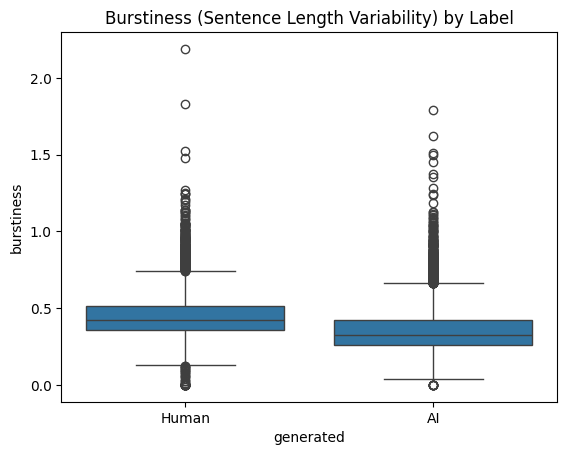

In [12]:
sns.boxplot(data=df, x='generated', y='burstiness')
plt.title("Burstiness (Sentence Length Variability) by Label")
plt.xticks([0, 1], ['Human', 'AI'])
plt.show()

Key Insights:
- Human texts show a bit more burstiness (higher burstiness = more variability in sentence length)
- AI texts are more consistent. They more better/more sentence structure
- Both have a lot of high-burstiness outliers, but humans have a wider spread which makes sense because we tend to have more natural or expressive writing.
- This supports the idea that humans vary sentence length more intuitively, while AI outputs are often more templated.


## Reviewing our EDA

In [13]:
# new features we have now
print(df.columns.tolist())

['text', 'generated', 'text_length', 'word_count', 'readability', 'gunning_fog', 'smog_index', 'burstiness']


In [14]:
print(df.sample(5)[['generated', 'text_length', 'word_count', 'readability', 'gunning_fog', 'smog_index', 'burstiness']])

       generated  text_length  word_count  readability  gunning_fog  \
15776          1         1912         339        41.90        13.19   
9493           0         2929         542        57.10        11.90   
22814          1         1265         235        53.92         9.61   
15105          0         2645         538        68.91         8.80   
807            0         4663         952        64.10         8.61   

       smog_index  burstiness  
15776        15.2    0.327872  
9493         13.1    0.476444  
22814        12.6    0.229748  
15105        10.5    0.521149  
807          10.3    0.452537  


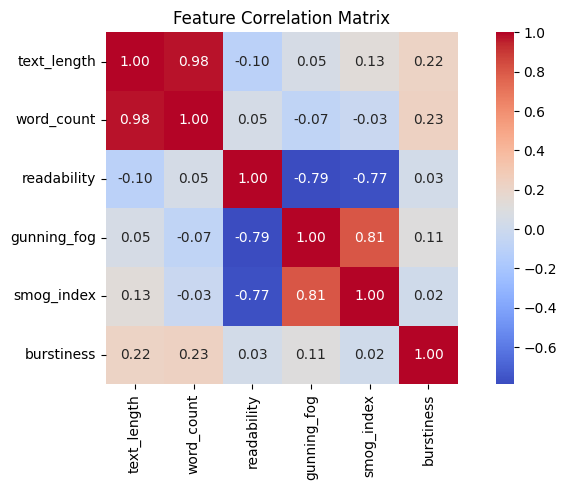

In [15]:
# correlation matrix
corr = df[['text_length', 'word_count', 'readability', 'gunning_fog', 'smog_index', 'burstiness']].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

Overall:
- We have a couple of new features like text_length, readability, and burstiness which hopefully can help us determine how to classify text as AI generated or human generated later on.
- We can still implement new features, or we can go into trying to start our initial models and investigate which algorithims would be the best for this type of classification.

### BERT Implementation

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv(filename)
df.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


check class distribution

In [20]:
df['generated'].value_counts(normalize=True)

generated
0    0.600721
1    0.399279
Name: proportion, dtype: float64

Split the dataset into training/test

In [21]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['generated'], 
test_size=0.3, random_state=2018, stratify=df['generated'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
 random_state=2018, test_size=0.5, stratify=temp_labels)

Import Bert - base- uncased


In [22]:
bert = AutoModel.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

 get length of all the texts in the train set


<Axes: >

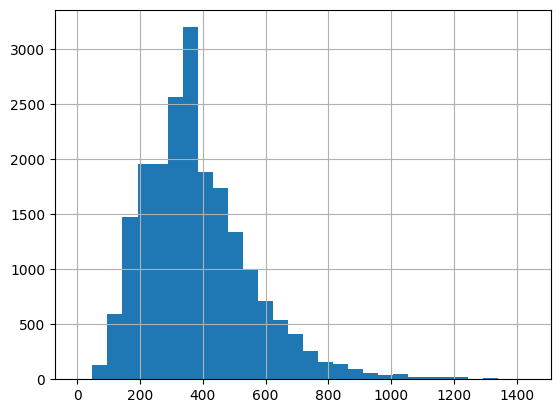

In [23]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

Tokenize & Encode the Sequences

In [24]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/Users/ezequiel/myenv/lib/python3.13/site-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


List to Tensors

In [25]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


Data Loader

In [55]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


Model Architecture

In [45]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [56]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

 pass the pre-trained BERT to our define architecture


In [57]:
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [58]:
from torch.optim import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

compute the class weights


In [60]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.83235414 1.25220967]


 converting list of class weights to a tensor


In [61]:
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

Fine - Tune

In [62]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 100 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [70]:
import time

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round(elapsed))
    return str(time.strftime("%H:%M:%S", time.gmtime(elapsed_rounded)))

Function to evaluate the model

In [69]:
import time 

def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()
    t0 = time.time()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [71]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch   100  of    638.
  Batch   200  of    638.
  Batch   300  of    638.
  Batch   400  of    638.
  Batch   500  of    638.
  Batch   600  of    638.

Evaluating...
  Batch   100  of    137.

Training Loss: 0.561
Validation Loss: 0.525

 Epoch 2 / 10
  Batch   100  of    638.
  Batch   200  of    638.
  Batch   300  of    638.
  Batch   400  of    638.
  Batch   500  of    638.
  Batch   600  of    638.

Evaluating...
  Batch   100  of    137.

Training Loss: 0.520
Validation Loss: 0.498

 Epoch 3 / 10
  Batch   100  of    638.
  Batch   200  of    638.
  Batch   300  of    638.
  Batch   400  of    638.
  Batch   500  of    638.
  Batch   600  of    638.

Evaluating...
  Batch   100  of    137.

Training Loss: 0.494
Validation Loss: 0.473

 Epoch 4 / 10
  Batch   100  of    638.
  Batch   200  of    638.
  Batch   300  of    638.
  Batch   400  of    638.
  Batch   500  of    638.
  Batch   600  of    638.

Evaluating...
  Batch   100  of    137.

Training Loss: 0

In [72]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Make Predictions

In [73]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      2627
           1       0.74      0.86      0.80      1745

    accuracy                           0.82      4372
   macro avg       0.82      0.83      0.82      4372
weighted avg       0.83      0.82      0.82      4372



The model achieved an overall accuracy of 82% in distinguishing between human-written and AI-generated text. It performed slightly better at identifying human-written content (class 0), with a precision of 0.89 and an F1-score of 0.84, indicating that when it predicts a text as human-written, it's correct most of the time.

Conversely, the model showed a higher recall for AI-generated text (class 1) at 0.86, meaning it's effective at detecting most AI-generated examples, though with slightly lower precision (0.74). This trade-off suggests the model prioritizes catching AI-generated content, even if it sometimes mislabels human-written text.

Overall, the model is well-balanced but slightly favors recall for AI-generated content, making it suitable for applications where minimizing false negatives for AI text (i.e., missing AI-generated samples) is more critical than false positives.